<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%88%98%ED%99%94%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 수화 이미지 분류 경진대회

## 패키지 import

In [2]:
# !pip install albumentations==0.4.6
# !pip install adabelief-pytorch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import warnings
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings(action = 'ignore')

In [4]:
SEED = 22
N_FOLD = 10
SAVE_PATH = './weight2'
LEARNING_RATE = 1e-3
EPOCHS = 500
BATCH_SIZE = 24

In [5]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [9]:
%cd '/content/drive/MyDrive/Colab Notebooks/수화이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/수화이미지-분류/Data


In [10]:
# !unzip -o '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data/user_data.zip의 사본'

In [11]:
%cd '/content/drive/MyDrive/Colab Notebooks/수화이미지-분류'

/content/drive/MyDrive/Colab Notebooks/수화이미지-분류


In [12]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


`-` 결측치는 없다

In [14]:
df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


`-` 파일 이름과 라벨명이 한 쌍으로 되어있음

## 데이터 셋 및 딥러닝 모델 정의

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
from adabelief_pytorch import AdaBelief
import gc

In [16]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [19]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [20]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 학습 이미지와 이미지 경로

In [21]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

In [22]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

In [23]:
# train_img_path_list = sorted(glob('./Data/train/*.png'))
# test_img_path_list = sorted(glob('./Data/test/*.png'))

- 데이터 셋과 데이터 로더

In [24]:
class CustomDataset(Dataset):
  
    def __init__(self, images: np.array, label_list, train_mode=True, transforms=None):
        self.images = images
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image'] ## albumentations.Compose는 인자를 kwargs로 받는다

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        
        return image ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images) ## 데이터 개수 반환

- 데이터 변환

In [25]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [27]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train_mode=True):
    transforms = A.Compose([
        A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
        ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
    ])
    
    if train_mode:
        transforms = A.Compose([
            # A.CenterCrop(196, 196), ## 높이 X 너비 크기의 이미지를 중앙에서 crop
            A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
            A.GaussNoise(p=0.5),
            A.RandomGamma(p=0.5),
            # A.Blur(blur_limit=(3, 5), p=0.5),
            A.RandomBrightnessContrast(p=0.5), ## 무작위로 밝기와 대비를 조절
            A.HorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            A.Rotate(limit=10, p=1), ## 무작위로 -limit~limit 각도 회전
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
            ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
        ])

    return transforms ## 데이터 변환 방식을 반환

`-` 라벨을 0~10로 변환하겠다

In [28]:
def get_label_map() -> dict:
    label_map = dict()
    label_map['10-1'] = 10
    label_map['10-2'] = 0
    
    for i in range(1, 10):
        label_map[str(i)] = i

    return label_map

In [29]:
def label_encoding_transform(label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    encoded_label = label.apply(lambda x: label_map[x])
    return encoded_label

In [30]:
def label_encoding_inverse_transform(encoded_label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    label_inverse_map = dict(zip(label_map.values(), label_map.keys()))
    label = encoded_label.apply(lambda x: label_inverse_map[x])
    return label

In [31]:
target = label_encoding_transform(df['label'])

- CNN 신경망

In [32]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn_model = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=1, padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            nn.GELU(),
            nn.BatchNorm2d(32),
  
            nn.Conv2d(32, 16, kernel_size=(4, 4), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(4, 4), stride=2), ## max pooling

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling
            
            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )

        self.linear_model = nn.Sequential(
            nn.Linear(16, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 11) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )
      
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.squeeze()
        x = self.linear_model(x)
        return x

- Linear layer 가중치 초기화

In [33]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1/np.sqrt(y))
        m.bias.data.fill_(0)

- 조기 중단

In [34]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

## 모델 교차검증

In [35]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [36]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.07)   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨, 라벨 스무딩 사용(오버피팅 방지)

In [37]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [38]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [39]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [40]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_images, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    X_train, X_valid = train_images[train_idx], train_images[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=70,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN().to(device)
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform(train_mode=True))
    valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    # optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    # optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9) 
    optimizer = AdaBelief(net.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=1e-2, betas=(0.9, 0.999), weight_decouple=True, rectify=False, print_change_log=False)
    
    ## scheduler  
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')     

[1 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.4928  valid loss = 2.4033


  2%|▏         | 11/500 [00:39<29:00,  3.56s/it]

[Epoch:  11] train loss = 2.0705  valid loss = 1.8838


  4%|▍         | 21/500 [01:15<28:26,  3.56s/it]

[Epoch:  21] train loss = 1.7624  valid loss = 1.5454


  6%|▌         | 31/500 [01:50<27:53,  3.57s/it]

[Epoch:  31] train loss = 1.6623  valid loss = 1.5076


  8%|▊         | 41/500 [02:26<27:19,  3.57s/it]

[Epoch:  41] train loss = 1.6511  valid loss = 1.4868


 10%|█         | 51/500 [03:02<26:50,  3.59s/it]

[Epoch:  51] train loss = 1.4864  valid loss = 1.3029


 12%|█▏        | 61/500 [03:37<26:05,  3.57s/it]

[Epoch:  61] train loss = 1.4565  valid loss = 1.2458


 14%|█▍        | 71/500 [04:13<25:19,  3.54s/it]

[Epoch:  71] train loss = 1.128  valid loss = 1.0109


 16%|█▌        | 81/500 [04:48<24:40,  3.53s/it]

[Epoch:  81] train loss = 0.97561  valid loss = 0.87242


 18%|█▊        | 91/500 [05:22<23:38,  3.47s/it]

[Epoch:  91] train loss = 0.92508  valid loss = 0.82328


 20%|██        | 101/500 [05:58<23:25,  3.52s/it]

[Epoch: 101] train loss = 0.91737  valid loss = 0.83504


 22%|██▏       | 111/500 [06:33<23:11,  3.58s/it]

[Epoch: 111] train loss = 1.018  valid loss = 0.88172


 24%|██▍       | 121/500 [07:08<21:53,  3.47s/it]

[Epoch: 121] train loss = 0.97815  valid loss = 0.81026


 26%|██▌       | 131/500 [07:44<21:32,  3.50s/it]

[Epoch: 131] train loss = 0.86622  valid loss = 0.8316


 28%|██▊       | 141/500 [08:19<21:01,  3.51s/it]

[Epoch: 141] train loss = 0.7934  valid loss = 0.75663


 30%|███       | 151/500 [08:54<20:08,  3.46s/it]

[Epoch: 151] train loss = 0.77643  valid loss = 0.73402


 32%|███▏      | 161/500 [09:28<19:37,  3.47s/it]

[Epoch: 161] train loss = 0.76643  valid loss = 0.75272


 34%|███▍      | 171/500 [10:03<19:01,  3.47s/it]

[Epoch: 171] train loss = 0.86821  valid loss = 0.86942


 36%|███▌      | 181/500 [10:38<18:49,  3.54s/it]

[Epoch: 181] train loss = 0.82182  valid loss = 0.69644


 38%|███▊      | 191/500 [11:13<18:11,  3.53s/it]

[Epoch: 191] train loss = 0.74041  valid loss = 0.75908


 40%|████      | 201/500 [11:50<18:23,  3.69s/it]

[Epoch: 201] train loss = 0.70516  valid loss = 0.66004


 42%|████▏     | 211/500 [12:25<16:57,  3.52s/it]

[Epoch: 211] train loss = 0.67172  valid loss = 0.64992


 44%|████▍     | 221/500 [13:00<16:26,  3.54s/it]

[Epoch: 221] train loss = 0.69201  valid loss = 0.6537


 46%|████▌     | 231/500 [13:35<15:33,  3.47s/it]

[Epoch: 231] train loss = 0.74248  valid loss = 0.7753


 48%|████▊     | 241/500 [14:10<15:08,  3.51s/it]

[Epoch: 241] train loss = 0.76092  valid loss = 0.80952


 50%|█████     | 251/500 [14:48<16:20,  3.94s/it]

[Epoch: 251] train loss = 0.69987  valid loss = 0.70571


 52%|█████▏    | 261/500 [15:22<13:49,  3.47s/it]

[Epoch: 261] train loss = 0.64732  valid loss = 0.63045


 54%|█████▍    | 271/500 [15:57<13:14,  3.47s/it]

[Epoch: 271] train loss = 0.64752  valid loss = 0.62369


 56%|█████▌    | 281/500 [16:31<12:41,  3.48s/it]

[Epoch: 281] train loss = 0.61543  valid loss = 0.63344


 58%|█████▊    | 291/500 [17:06<11:58,  3.44s/it]

[Epoch: 291] train loss = 0.67936  valid loss = 0.7218


 60%|██████    | 301/500 [17:41<11:23,  3.43s/it]

[Epoch: 301] train loss = 0.71971  valid loss = 0.67486


 62%|██████▏   | 311/500 [18:15<10:54,  3.46s/it]

[Epoch: 311] train loss = 0.6925  valid loss = 0.70769


 64%|██████▍   | 321/500 [18:49<10:05,  3.38s/it]

[Epoch: 321] train loss = 0.62973  valid loss = 0.62265


 65%|██████▍   | 324/500 [19:02<10:20,  3.53s/it]


[Epoch: 325] train loss = 0.61599  valid loss = 0.67412
Early stopping!
1 Fold -> Best Valid Loss: 0.6046  Best Valid Accuracy: 0.9535


[2 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.5161  valid loss = 2.4003


  2%|▏         | 11/500 [00:38<28:15,  3.47s/it]

[Epoch:  11] train loss = 2.0207  valid loss = 1.9226


  4%|▍         | 21/500 [01:12<27:51,  3.49s/it]

[Epoch:  21] train loss = 1.6674  valid loss = 1.5065


  6%|▌         | 31/500 [01:47<26:51,  3.44s/it]

[Epoch:  31] train loss = 1.5515  valid loss = 1.3854


  8%|▊         | 41/500 [02:21<26:28,  3.46s/it]

[Epoch:  41] train loss = 1.5089  valid loss = 1.3748


 10%|█         | 51/500 [02:55<25:33,  3.42s/it]

[Epoch:  51] train loss = 1.444  valid loss = 1.4503


 12%|█▏        | 61/500 [03:30<25:18,  3.46s/it]

[Epoch:  61] train loss = 1.304  valid loss = 1.1181


 14%|█▍        | 71/500 [04:05<25:02,  3.50s/it]

[Epoch:  71] train loss = 1.1197  valid loss = 0.96995


 16%|█▌        | 81/500 [04:40<24:20,  3.49s/it]

[Epoch:  81] train loss = 0.98973  valid loss = 0.86367


 18%|█▊        | 91/500 [05:14<23:32,  3.45s/it]

[Epoch:  91] train loss = 0.93788  valid loss = 0.83938


 20%|██        | 101/500 [05:48<22:46,  3.43s/it]

[Epoch: 101] train loss = 0.95889  valid loss = 0.87425


 22%|██▏       | 111/500 [06:23<22:09,  3.42s/it]

[Epoch: 111] train loss = 1.0254  valid loss = 0.90244


 24%|██▍       | 121/500 [06:57<21:30,  3.40s/it]

[Epoch: 121] train loss = 1.004  valid loss = 1.0479


 26%|██▌       | 131/500 [07:31<21:15,  3.46s/it]

[Epoch: 131] train loss = 0.93551  valid loss = 0.83356


 28%|██▊       | 141/500 [08:06<20:59,  3.51s/it]

[Epoch: 141] train loss = 0.78224  valid loss = 0.71676


 30%|███       | 151/500 [08:41<19:54,  3.42s/it]

[Epoch: 151] train loss = 0.80339  valid loss = 0.68525


 32%|███▏      | 161/500 [09:15<19:35,  3.47s/it]

[Epoch: 161] train loss = 0.77668  valid loss = 0.72806


 34%|███▍      | 171/500 [09:50<19:12,  3.50s/it]

[Epoch: 171] train loss = 0.93571  valid loss = 0.90299


 36%|███▌      | 181/500 [10:26<18:35,  3.50s/it]

[Epoch: 181] train loss = 0.79647  valid loss = 0.73491


 38%|███▊      | 191/500 [11:01<18:16,  3.55s/it]

[Epoch: 191] train loss = 0.78179  valid loss = 0.7486


 40%|████      | 201/500 [11:36<17:39,  3.54s/it]

[Epoch: 201] train loss = 0.71507  valid loss = 0.63899


 42%|████▏     | 211/500 [12:12<17:01,  3.53s/it]

[Epoch: 211] train loss = 0.66925  valid loss = 0.58705


 44%|████▍     | 221/500 [12:47<16:07,  3.47s/it]

[Epoch: 221] train loss = 0.6914  valid loss = 0.5689


 46%|████▌     | 231/500 [13:21<15:32,  3.47s/it]

[Epoch: 231] train loss = 0.7509  valid loss = 0.67575


 48%|████▊     | 241/500 [13:56<15:08,  3.51s/it]

[Epoch: 241] train loss = 0.7537  valid loss = 0.66684


 50%|█████     | 251/500 [14:31<14:17,  3.44s/it]

[Epoch: 251] train loss = 0.71835  valid loss = 0.59516


 52%|█████▏    | 261/500 [15:06<13:52,  3.48s/it]

[Epoch: 261] train loss = 0.63534  valid loss = 0.54701


 54%|█████▍    | 271/500 [15:40<12:55,  3.39s/it]

[Epoch: 271] train loss = 0.63483  valid loss = 0.55758


 56%|█████▌    | 281/500 [16:14<12:42,  3.48s/it]

[Epoch: 281] train loss = 0.6303  valid loss = 0.5407


 58%|█████▊    | 291/500 [16:49<11:58,  3.44s/it]

[Epoch: 291] train loss = 0.72404  valid loss = 0.62989


 60%|██████    | 301/500 [17:23<11:20,  3.42s/it]

[Epoch: 301] train loss = 0.73121  valid loss = 0.68241


 62%|██████▏   | 311/500 [17:57<10:44,  3.41s/it]

[Epoch: 311] train loss = 0.6685  valid loss = 0.57461


 64%|██████▍   | 321/500 [18:32<10:20,  3.47s/it]

[Epoch: 321] train loss = 0.63647  valid loss = 0.54948


 66%|██████▌   | 331/500 [19:06<09:44,  3.46s/it]

[Epoch: 331] train loss = 0.61306  valid loss = 0.53741


 68%|██████▊   | 341/500 [19:41<09:16,  3.50s/it]

[Epoch: 341] train loss = 0.60887  valid loss = 0.53669


 70%|███████   | 351/500 [20:16<08:39,  3.49s/it]

[Epoch: 351] train loss = 0.7644  valid loss = 0.65934


 72%|███████▏  | 361/500 [20:51<08:08,  3.52s/it]

[Epoch: 361] train loss = 0.66113  valid loss = 0.56011


 74%|███████▍  | 371/500 [21:26<07:29,  3.48s/it]

[Epoch: 371] train loss = 0.65873  valid loss = 0.57835


 76%|███████▌  | 381/500 [22:01<06:56,  3.50s/it]

[Epoch: 381] train loss = 0.60506  valid loss = 0.5277


 78%|███████▊  | 391/500 [22:35<06:19,  3.48s/it]

[Epoch: 391] train loss = 0.58282  valid loss = 0.51444


 80%|████████  | 401/500 [23:10<05:38,  3.42s/it]

[Epoch: 401] train loss = 0.58246  valid loss = 0.51799


 82%|████████▏ | 411/500 [23:45<05:12,  3.51s/it]

[Epoch: 411] train loss = 0.59491  valid loss = 0.53801


 84%|████████▍ | 421/500 [24:21<04:42,  3.58s/it]

[Epoch: 421] train loss = 0.6521  valid loss = 0.58184


 86%|████████▌ | 431/500 [24:55<03:58,  3.45s/it]

[Epoch: 431] train loss = 0.59937  valid loss = 0.52579


 88%|████████▊ | 441/500 [25:30<03:26,  3.49s/it]

[Epoch: 441] train loss = 0.56727  valid loss = 0.49891


 90%|█████████ | 451/500 [26:05<02:53,  3.54s/it]

[Epoch: 451] train loss = 0.5508  valid loss = 0.4876


 92%|█████████▏| 461/500 [26:40<02:15,  3.48s/it]

[Epoch: 461] train loss = 0.59437  valid loss = 0.52436


 94%|█████████▍| 471/500 [27:15<01:40,  3.48s/it]

[Epoch: 471] train loss = 0.64784  valid loss = 0.58542


 96%|█████████▌| 481/500 [27:49<01:05,  3.45s/it]

[Epoch: 481] train loss = 0.59922  valid loss = 0.56564


 98%|█████████▊| 491/500 [28:23<00:30,  3.41s/it]

[Epoch: 491] train loss = 0.60865  valid loss = 0.54234


100%|██████████| 500/500 [28:54<00:00,  3.47s/it]


[Epoch: 500] train loss = 0.55731  valid loss = 0.50431
2 Fold -> Best Valid Loss: 0.4876  Best Valid Accuracy: 1.0000


[3 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.507  valid loss = 2.4421


  2%|▏         | 11/500 [00:38<28:37,  3.51s/it]

[Epoch:  11] train loss = 2.0982  valid loss = 2.0069


  4%|▍         | 21/500 [01:13<27:46,  3.48s/it]

[Epoch:  21] train loss = 1.7872  valid loss = 1.6533


  6%|▌         | 31/500 [01:47<26:25,  3.38s/it]

[Epoch:  31] train loss = 1.6735  valid loss = 1.5671


  8%|▊         | 41/500 [02:21<25:58,  3.39s/it]

[Epoch:  41] train loss = 1.6672  valid loss = 1.5451


 10%|█         | 51/500 [02:55<25:15,  3.38s/it]

[Epoch:  51] train loss = 1.5552  valid loss = 1.4693


 12%|█▏        | 61/500 [03:30<25:23,  3.47s/it]

[Epoch:  61] train loss = 1.3359  valid loss = 1.2217


 14%|█▍        | 71/500 [04:04<24:14,  3.39s/it]

[Epoch:  71] train loss = 1.174  valid loss = 1.1109


 16%|█▌        | 81/500 [04:39<23:46,  3.40s/it]

[Epoch:  81] train loss = 0.99041  valid loss = 0.91238


 18%|█▊        | 91/500 [05:13<23:19,  3.42s/it]

[Epoch:  91] train loss = 0.97468  valid loss = 0.95281


 20%|██        | 101/500 [05:47<22:47,  3.43s/it]

[Epoch: 101] train loss = 0.95697  valid loss = 0.89637


 22%|██▏       | 111/500 [06:22<22:42,  3.50s/it]

[Epoch: 111] train loss = 1.026  valid loss = 0.99394


 24%|██▍       | 121/500 [06:56<21:32,  3.41s/it]

[Epoch: 121] train loss = 0.96337  valid loss = 1.1135


 26%|██▌       | 131/500 [07:30<21:06,  3.43s/it]

[Epoch: 131] train loss = 0.86126  valid loss = 0.90563


 28%|██▊       | 141/500 [08:04<20:30,  3.43s/it]

[Epoch: 141] train loss = 0.79858  valid loss = 0.78922


 30%|███       | 151/500 [08:38<19:44,  3.39s/it]

[Epoch: 151] train loss = 0.74898  valid loss = 0.76144


 32%|███▏      | 161/500 [09:13<19:33,  3.46s/it]

[Epoch: 161] train loss = 0.73444  valid loss = 0.78188


 34%|███▍      | 171/500 [09:48<19:12,  3.50s/it]

[Epoch: 171] train loss = 0.82106  valid loss = 0.83761


 36%|███▌      | 181/500 [10:22<18:17,  3.44s/it]

[Epoch: 181] train loss = 0.80956  valid loss = 1.0247


 38%|███▊      | 191/500 [10:57<17:36,  3.42s/it]

[Epoch: 191] train loss = 0.75165  valid loss = 0.78892


 40%|████      | 201/500 [11:31<17:03,  3.42s/it]

[Epoch: 201] train loss = 0.66912  valid loss = 0.76412


 42%|████▏     | 211/500 [12:09<17:08,  3.56s/it]

[Epoch: 211] train loss = 0.64523  valid loss = 0.75435


 44%|████▍     | 221/500 [12:44<16:22,  3.52s/it]

[Epoch: 221] train loss = 0.68827  valid loss = 0.72692


 46%|████▌     | 231/500 [13:18<15:10,  3.38s/it]

[Epoch: 231] train loss = 0.75432  valid loss = 0.81715


 48%|████▊     | 241/500 [13:52<14:58,  3.47s/it]

[Epoch: 241] train loss = 0.73737  valid loss = 0.86688


 50%|█████     | 251/500 [14:26<13:59,  3.37s/it]

[Epoch: 251] train loss = 0.6623  valid loss = 0.84265


 52%|█████▏    | 261/500 [15:01<13:52,  3.48s/it]

[Epoch: 261] train loss = 0.62257  valid loss = 0.74322


 54%|█████▍    | 271/500 [15:36<13:18,  3.49s/it]

[Epoch: 271] train loss = 0.62759  valid loss = 0.70039


 56%|█████▌    | 281/500 [16:10<12:37,  3.46s/it]

[Epoch: 281] train loss = 0.63212  valid loss = 0.71201


 58%|█████▊    | 291/500 [16:45<12:12,  3.51s/it]

[Epoch: 291] train loss = 0.66672  valid loss = 0.79163


 60%|██████    | 301/500 [17:19<11:36,  3.50s/it]

[Epoch: 301] train loss = 0.68266  valid loss = 0.82414


 62%|██████▏   | 311/500 [17:54<10:48,  3.43s/it]

[Epoch: 311] train loss = 0.65146  valid loss = 0.74849


 64%|██████▍   | 321/500 [18:28<10:13,  3.43s/it]

[Epoch: 321] train loss = 0.59297  valid loss = 0.69858


 66%|██████▌   | 328/500 [18:55<09:55,  3.46s/it]


[Epoch: 329] train loss = 0.57048  valid loss = 0.74543
Early stopping!
3 Fold -> Best Valid Loss: 0.6789  Best Valid Accuracy: 0.9070


[4 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.5789  valid loss = 2.443


  2%|▏         | 11/500 [00:38<28:25,  3.49s/it]

[Epoch:  11] train loss = 2.1182  valid loss = 2.0666


  4%|▍         | 21/500 [01:13<27:23,  3.43s/it]

[Epoch:  21] train loss = 1.8068  valid loss = 1.7437


  6%|▌         | 31/500 [01:47<27:01,  3.46s/it]

[Epoch:  31] train loss = 1.745  valid loss = 1.6874


  8%|▊         | 41/500 [02:21<26:01,  3.40s/it]

[Epoch:  41] train loss = 1.7225  valid loss = 1.6169


 10%|█         | 51/500 [02:55<25:20,  3.39s/it]

[Epoch:  51] train loss = 1.624  valid loss = 1.7505


 12%|█▏        | 61/500 [03:30<25:38,  3.51s/it]

[Epoch:  61] train loss = 1.5091  valid loss = 1.5142


 14%|█▍        | 71/500 [04:04<24:42,  3.46s/it]

[Epoch:  71] train loss = 1.3004  valid loss = 1.2906


 16%|█▌        | 81/500 [04:39<23:40,  3.39s/it]

[Epoch:  81] train loss = 1.1079  valid loss = 1.1207


 18%|█▊        | 91/500 [05:13<23:33,  3.46s/it]

[Epoch:  91] train loss = 1.061  valid loss = 1.0564


 20%|██        | 101/500 [05:47<23:09,  3.48s/it]

[Epoch: 101] train loss = 1.0734  valid loss = 1.0411


 22%|██▏       | 111/500 [06:22<21:59,  3.39s/it]

[Epoch: 111] train loss = 1.13  valid loss = 1.1158


 24%|██▍       | 121/500 [06:56<22:01,  3.49s/it]

[Epoch: 121] train loss = 1.013  valid loss = 1.0228


 26%|██▌       | 131/500 [07:31<21:27,  3.49s/it]

[Epoch: 131] train loss = 0.94545  valid loss = 1.0374


 28%|██▊       | 141/500 [08:06<20:58,  3.50s/it]

[Epoch: 141] train loss = 0.84991  valid loss = 0.95957


 30%|███       | 151/500 [08:41<20:13,  3.48s/it]

[Epoch: 151] train loss = 0.8104  valid loss = 0.85948


 32%|███▏      | 161/500 [09:15<19:16,  3.41s/it]

[Epoch: 161] train loss = 0.7968  valid loss = 0.87034


 34%|███▍      | 171/500 [09:49<18:39,  3.40s/it]

[Epoch: 171] train loss = 0.89374  valid loss = 0.9065


 36%|███▌      | 181/500 [10:23<18:26,  3.47s/it]

[Epoch: 181] train loss = 0.91459  valid loss = 0.94856


 38%|███▊      | 191/500 [10:57<17:13,  3.34s/it]

[Epoch: 191] train loss = 0.76695  valid loss = 0.81653


 40%|████      | 201/500 [11:32<17:16,  3.47s/it]

[Epoch: 201] train loss = 0.75796  valid loss = 0.73064


 42%|████▏     | 211/500 [12:06<16:35,  3.44s/it]

[Epoch: 211] train loss = 0.68376  valid loss = 0.71158


 44%|████▍     | 221/500 [12:41<16:07,  3.47s/it]

[Epoch: 221] train loss = 0.71931  valid loss = 0.77163


 46%|████▌     | 231/500 [13:15<15:38,  3.49s/it]

[Epoch: 231] train loss = 0.74227  valid loss = 0.77016


 48%|████▊     | 241/500 [13:50<14:37,  3.39s/it]

[Epoch: 241] train loss = 0.83504  valid loss = 0.93579


 50%|█████     | 251/500 [14:24<14:17,  3.44s/it]

[Epoch: 251] train loss = 0.76764  valid loss = 0.72828


 52%|█████▏    | 261/500 [14:59<13:35,  3.41s/it]

[Epoch: 261] train loss = 0.6603  valid loss = 0.75623


 54%|█████▍    | 271/500 [15:34<13:23,  3.51s/it]

[Epoch: 271] train loss = 0.63677  valid loss = 0.71016


 56%|█████▌    | 281/500 [16:08<12:27,  3.41s/it]

[Epoch: 281] train loss = 0.62399  valid loss = 0.80734


 57%|█████▋    | 284/500 [16:22<12:27,  3.46s/it]


[Epoch: 285] train loss = 0.65951  valid loss = 0.77949
Early stopping!
4 Fold -> Best Valid Loss: 0.7063  Best Valid Accuracy: 0.9070


[5 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.528  valid loss = 2.3596


  2%|▏         | 11/500 [00:38<27:59,  3.43s/it]

[Epoch:  11] train loss = 1.9488  valid loss = 1.91


  4%|▍         | 21/500 [01:12<27:00,  3.38s/it]

[Epoch:  21] train loss = 1.6342  valid loss = 1.5684


  6%|▌         | 31/500 [01:46<25:57,  3.32s/it]

[Epoch:  31] train loss = 1.524  valid loss = 1.4894


  8%|▊         | 41/500 [02:20<26:27,  3.46s/it]

[Epoch:  41] train loss = 1.4972  valid loss = 1.4197


 10%|█         | 51/500 [02:53<25:11,  3.37s/it]

[Epoch:  51] train loss = 1.3952  valid loss = 1.3721


 12%|█▏        | 61/500 [03:28<25:15,  3.45s/it]

[Epoch:  61] train loss = 1.2672  valid loss = 1.1105


 14%|█▍        | 71/500 [04:02<24:09,  3.38s/it]

[Epoch:  71] train loss = 1.0138  valid loss = 1.0854


 16%|█▌        | 81/500 [04:36<23:54,  3.42s/it]

[Epoch:  81] train loss = 0.92006  valid loss = 1.0098


 18%|█▊        | 91/500 [05:09<22:59,  3.37s/it]

[Epoch:  91] train loss = 0.88236  valid loss = 1.0037


 20%|██        | 101/500 [05:44<23:07,  3.48s/it]

[Epoch: 101] train loss = 0.90469  valid loss = 0.99413


 22%|██▏       | 111/500 [06:19<22:26,  3.46s/it]

[Epoch: 111] train loss = 1.0097  valid loss = 1.0375


 24%|██▍       | 121/500 [06:53<21:22,  3.38s/it]

[Epoch: 121] train loss = 0.9033  valid loss = 1.0125


 26%|██▌       | 131/500 [07:27<21:33,  3.50s/it]

[Epoch: 131] train loss = 0.84564  valid loss = 0.9267


 28%|██▊       | 141/500 [08:02<20:58,  3.51s/it]

[Epoch: 141] train loss = 0.75164  valid loss = 0.84801


 30%|███       | 151/500 [08:37<20:24,  3.51s/it]

[Epoch: 151] train loss = 0.71834  valid loss = 0.86622


 32%|███▏      | 161/500 [09:12<19:21,  3.43s/it]

[Epoch: 161] train loss = 0.74794  valid loss = 0.90203


 34%|███▍      | 171/500 [09:47<19:14,  3.51s/it]

[Epoch: 171] train loss = 0.80231  valid loss = 0.97317


 36%|███▌      | 181/500 [10:21<18:31,  3.48s/it]

[Epoch: 181] train loss = 0.79928  valid loss = 1.0572


 38%|███▊      | 191/500 [10:55<17:20,  3.37s/it]

[Epoch: 191] train loss = 0.76861  valid loss = 0.88813


 40%|████      | 201/500 [11:29<16:29,  3.31s/it]

[Epoch: 201] train loss = 0.68042  valid loss = 0.93627


 42%|████▏     | 211/500 [12:03<16:15,  3.38s/it]

[Epoch: 211] train loss = 0.65977  valid loss = 0.87715


 44%|████▍     | 221/500 [12:36<15:29,  3.33s/it]

[Epoch: 221] train loss = 0.65166  valid loss = 0.92353


 46%|████▌     | 231/500 [13:11<15:17,  3.41s/it]

[Epoch: 231] train loss = 0.69775  valid loss = 0.93962


 48%|████▊     | 241/500 [13:45<15:30,  3.59s/it]

[Epoch: 241] train loss = 0.77177  valid loss = 0.93222


 50%|█████     | 251/500 [14:23<14:20,  3.46s/it]

[Epoch: 251] train loss = 0.75062  valid loss = 0.94414


 52%|█████▏    | 261/500 [14:57<13:20,  3.35s/it]

[Epoch: 261] train loss = 0.63896  valid loss = 0.9144


 54%|█████▍    | 271/500 [15:32<13:30,  3.54s/it]

[Epoch: 271] train loss = 0.61258  valid loss = 0.91314


 56%|█████▌    | 281/500 [16:05<11:57,  3.28s/it]

[Epoch: 281] train loss = 0.62124  valid loss = 0.919


 58%|█████▊    | 291/500 [16:39<11:53,  3.42s/it]

[Epoch: 291] train loss = 0.72821  valid loss = 1.0399


 60%|██████    | 301/500 [17:13<11:17,  3.40s/it]

[Epoch: 301] train loss = 0.67126  valid loss = 0.89633


 62%|██████▏   | 311/500 [17:46<10:25,  3.31s/it]

[Epoch: 311] train loss = 0.62795  valid loss = 0.8551


 63%|██████▎   | 316/500 [18:07<10:32,  3.44s/it]


[Epoch: 317] train loss = 0.58709  valid loss = 0.88205
Early stopping!
5 Fold -> Best Valid Loss: 0.8041  Best Valid Accuracy: 0.8837


[6 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch:   1] train loss = 2.5244  valid loss = 2.3831


  2%|▏         | 11/500 [00:37<27:29,  3.37s/it]

[Epoch:  11] train loss = 2.0394  valid loss = 1.8835


  4%|▍         | 21/500 [01:11<27:22,  3.43s/it]

[Epoch:  21] train loss = 1.7739  valid loss = 1.6216


  6%|▌         | 31/500 [01:45<26:03,  3.33s/it]

[Epoch:  31] train loss = 1.6448  valid loss = 1.4823


  8%|▊         | 41/500 [02:19<26:16,  3.43s/it]

[Epoch:  41] train loss = 1.6265  valid loss = 1.4949


 10%|█         | 51/500 [02:53<25:32,  3.41s/it]

[Epoch:  51] train loss = 1.532  valid loss = 1.612


 12%|█▏        | 61/500 [03:27<24:17,  3.32s/it]

[Epoch:  61] train loss = 1.4304  valid loss = 1.2781


 14%|█▍        | 71/500 [04:02<24:23,  3.41s/it]

[Epoch:  71] train loss = 1.2684  valid loss = 1.1725


 16%|█▌        | 81/500 [04:36<24:08,  3.46s/it]

[Epoch:  81] train loss = 1.0384  valid loss = 1.0337


 18%|█▊        | 91/500 [05:11<23:11,  3.40s/it]

[Epoch:  91] train loss = 1.0063  valid loss = 0.99324


 20%|██        | 101/500 [05:45<23:00,  3.46s/it]

[Epoch: 101] train loss = 1.031  valid loss = 0.97489


 22%|██▏       | 111/500 [06:20<22:52,  3.53s/it]

[Epoch: 111] train loss = 1.0496  valid loss = 1.1589


 24%|██▍       | 121/500 [06:54<21:51,  3.46s/it]

[Epoch: 121] train loss = 1.0262  valid loss = 1.0821


 26%|██▌       | 131/500 [07:29<21:32,  3.50s/it]

[Epoch: 131] train loss = 0.89237  valid loss = 0.90606


 28%|██▊       | 141/500 [08:04<20:48,  3.48s/it]

[Epoch: 141] train loss = 0.81861  valid loss = 0.93837


 30%|███       | 151/500 [08:38<19:45,  3.40s/it]

[Epoch: 151] train loss = 0.85709  valid loss = 0.86853


 32%|███▏      | 161/500 [09:12<19:28,  3.45s/it]

[Epoch: 161] train loss = 0.80326  valid loss = 0.92925


 34%|███▍      | 171/500 [09:47<18:52,  3.44s/it]

[Epoch: 171] train loss = 0.9468  valid loss = 1.0148


 36%|███▌      | 181/500 [10:21<18:15,  3.44s/it]

[Epoch: 181] train loss = 0.83436  valid loss = 0.90361


 38%|███▊      | 191/500 [10:56<17:49,  3.46s/it]

[Epoch: 191] train loss = 0.86011  valid loss = 0.97751


 40%|████      | 201/500 [11:30<17:11,  3.45s/it]

[Epoch: 201] train loss = 0.73265  valid loss = 0.78913


 42%|████▏     | 211/500 [12:04<16:30,  3.43s/it]

[Epoch: 211] train loss = 0.70644  valid loss = 0.82128


 44%|████▍     | 221/500 [12:39<15:50,  3.41s/it]

[Epoch: 221] train loss = 0.67274  valid loss = 0.85715


 46%|████▌     | 231/500 [13:13<15:26,  3.45s/it]

[Epoch: 231] train loss = 0.78922  valid loss = 0.87419


 48%|████▊     | 241/500 [13:48<14:57,  3.47s/it]

[Epoch: 241] train loss = 0.73202  valid loss = 0.81951


 50%|█████     | 251/500 [14:23<14:19,  3.45s/it]

[Epoch: 251] train loss = 0.71974  valid loss = 0.8345


 52%|█████▏    | 261/500 [14:57<13:52,  3.48s/it]

[Epoch: 261] train loss = 0.69267  valid loss = 0.7942


 54%|█████▍    | 271/500 [15:31<12:57,  3.40s/it]

[Epoch: 271] train loss = 0.62736  valid loss = 0.74271


 56%|█████▌    | 281/500 [16:05<12:29,  3.42s/it]

[Epoch: 281] train loss = 0.64645  valid loss = 0.75505


 58%|█████▊    | 291/500 [16:40<12:10,  3.49s/it]

[Epoch: 291] train loss = 0.73124  valid loss = 0.80994


 60%|██████    | 301/500 [17:14<11:23,  3.43s/it]

[Epoch: 301] train loss = 0.72352  valid loss = 0.81734


 62%|██████▏   | 311/500 [17:48<10:44,  3.41s/it]

[Epoch: 311] train loss = 0.67694  valid loss = 0.84092


 64%|██████▍   | 321/500 [18:22<10:10,  3.41s/it]

[Epoch: 321] train loss = 0.61352  valid loss = 0.74392


 66%|██████▌   | 331/500 [18:57<09:41,  3.44s/it]

[Epoch: 331] train loss = 0.6131  valid loss = 0.71661


 68%|██████▊   | 341/500 [19:31<08:59,  3.39s/it]

[Epoch: 341] train loss = 0.62558  valid loss = 0.73706


 70%|███████   | 351/500 [20:04<08:14,  3.32s/it]

[Epoch: 351] train loss = 0.64845  valid loss = 0.76149


 72%|███████▏  | 361/500 [20:38<07:49,  3.38s/it]

[Epoch: 361] train loss = 0.79418  valid loss = 0.76455


 74%|███████▍  | 371/500 [21:12<07:13,  3.36s/it]

[Epoch: 371] train loss = 0.6317  valid loss = 0.72169


 76%|███████▌  | 381/500 [21:46<06:48,  3.43s/it]

[Epoch: 381] train loss = 0.58838  valid loss = 0.7407


 78%|███████▊  | 391/500 [22:20<06:14,  3.44s/it]

[Epoch: 391] train loss = 0.57468  valid loss = 0.71158


 79%|███████▉  | 394/500 [22:33<06:04,  3.44s/it]


[Epoch: 395] train loss = 0.58199  valid loss = 0.73884
Early stopping!
6 Fold -> Best Valid Loss: 0.6992  Best Valid Accuracy: 0.8837


[7 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/500 [00:03<28:23,  3.41s/it]

[Epoch:   1] train loss = 2.4923  valid loss = 2.4099


  2%|▏         | 11/500 [00:37<28:29,  3.50s/it]

[Epoch:  11] train loss = 1.9887  valid loss = 1.9518


  4%|▍         | 21/500 [01:12<27:09,  3.40s/it]

[Epoch:  21] train loss = 1.64  valid loss = 1.6472


  6%|▌         | 31/500 [01:44<25:18,  3.24s/it]

[Epoch:  31] train loss = 1.5429  valid loss = 1.564


  8%|▊         | 41/500 [02:18<25:56,  3.39s/it]

[Epoch:  41] train loss = 1.4873  valid loss = 1.4635


 10%|█         | 51/500 [02:52<25:02,  3.35s/it]

[Epoch:  51] train loss = 1.4877  valid loss = 1.6388


 12%|█▏        | 61/500 [03:25<24:03,  3.29s/it]

[Epoch:  61] train loss = 1.3103  valid loss = 1.5695


 14%|█▍        | 71/500 [03:59<24:13,  3.39s/it]

[Epoch:  71] train loss = 1.1306  valid loss = 1.1355


 16%|█▌        | 81/500 [04:33<23:52,  3.42s/it]

[Epoch:  81] train loss = 1.0055  valid loss = 1.0285


 18%|█▊        | 91/500 [05:07<23:00,  3.38s/it]

[Epoch:  91] train loss = 0.93273  valid loss = 0.9641


 20%|██        | 101/500 [05:40<21:47,  3.28s/it]

[Epoch: 101] train loss = 0.99686  valid loss = 0.97901


 22%|██▏       | 111/500 [06:14<22:04,  3.41s/it]

[Epoch: 111] train loss = 0.96973  valid loss = 1.1203


 24%|██▍       | 121/500 [06:47<21:10,  3.35s/it]

[Epoch: 121] train loss = 0.9819  valid loss = 0.96804


 26%|██▌       | 131/500 [07:20<20:01,  3.26s/it]

[Epoch: 131] train loss = 0.89587  valid loss = 0.8334


 28%|██▊       | 141/500 [07:54<20:03,  3.35s/it]

[Epoch: 141] train loss = 0.82468  valid loss = 0.82492


 30%|███       | 151/500 [08:27<19:24,  3.34s/it]

[Epoch: 151] train loss = 0.73839  valid loss = 0.8191


 32%|███▏      | 161/500 [09:01<19:01,  3.37s/it]

[Epoch: 161] train loss = 0.75389  valid loss = 0.79424


 34%|███▍      | 171/500 [09:34<18:24,  3.36s/it]

[Epoch: 171] train loss = 0.79799  valid loss = 0.93493


 36%|███▌      | 181/500 [10:08<17:46,  3.34s/it]

[Epoch: 181] train loss = 0.79423  valid loss = 0.85911


 38%|███▊      | 191/500 [10:41<17:05,  3.32s/it]

[Epoch: 191] train loss = 0.76373  valid loss = 0.79861


 40%|████      | 201/500 [11:15<17:16,  3.47s/it]

[Epoch: 201] train loss = 0.69646  valid loss = 0.74347


 42%|████▏     | 211/500 [11:49<16:30,  3.43s/it]

[Epoch: 211] train loss = 0.68005  valid loss = 0.75388


 44%|████▍     | 221/500 [12:22<15:17,  3.29s/it]

[Epoch: 221] train loss = 0.69204  valid loss = 0.81088


 46%|████▌     | 231/500 [12:56<15:19,  3.42s/it]

[Epoch: 231] train loss = 0.72286  valid loss = 0.8029


 48%|████▊     | 241/500 [13:30<14:41,  3.40s/it]

[Epoch: 241] train loss = 0.7544  valid loss = 0.80334


 50%|█████     | 251/500 [14:04<13:57,  3.36s/it]

[Epoch: 251] train loss = 0.69765  valid loss = 0.75935


 52%|█████▏    | 261/500 [14:38<13:41,  3.44s/it]

[Epoch: 261] train loss = 0.6543  valid loss = 0.76005


 54%|█████▍    | 271/500 [15:12<12:55,  3.39s/it]

[Epoch: 271] train loss = 0.61978  valid loss = 0.70303


 56%|█████▌    | 281/500 [15:46<12:24,  3.40s/it]

[Epoch: 281] train loss = 0.60641  valid loss = 0.74376


 58%|█████▊    | 291/500 [16:20<11:56,  3.43s/it]

[Epoch: 291] train loss = 0.71915  valid loss = 0.78556


 60%|██████    | 301/500 [16:55<11:27,  3.45s/it]

[Epoch: 301] train loss = 0.75355  valid loss = 0.80057


 62%|██████▏   | 311/500 [17:31<10:58,  3.48s/it]

[Epoch: 311] train loss = 0.68929  valid loss = 0.77565


 64%|██████▍   | 321/500 [18:05<10:14,  3.44s/it]

[Epoch: 321] train loss = 0.59831  valid loss = 0.72664


 66%|██████▌   | 331/500 [18:39<09:32,  3.39s/it]

[Epoch: 331] train loss = 0.58805  valid loss = 0.73105


 68%|██████▊   | 341/500 [19:13<08:58,  3.38s/it]

[Epoch: 341] train loss = 0.58083  valid loss = 0.7008


 70%|███████   | 351/500 [19:47<08:26,  3.40s/it]

[Epoch: 351] train loss = 0.67153  valid loss = 0.78908


 72%|███████▏  | 361/500 [20:21<07:54,  3.41s/it]

[Epoch: 361] train loss = 0.64588  valid loss = 0.80017


 74%|███████▍  | 371/500 [20:55<07:13,  3.36s/it]

[Epoch: 371] train loss = 0.62594  valid loss = 0.7929


 76%|███████▌  | 381/500 [21:30<06:50,  3.45s/it]

[Epoch: 381] train loss = 0.5997  valid loss = 0.72623


 78%|███████▊  | 391/500 [22:04<06:18,  3.47s/it]

[Epoch: 391] train loss = 0.59346  valid loss = 0.70376


 80%|████████  | 401/500 [22:39<05:45,  3.49s/it]

[Epoch: 401] train loss = 0.56914  valid loss = 0.70628


 82%|████████▏ | 411/500 [23:13<04:56,  3.33s/it]

[Epoch: 411] train loss = 0.68885  valid loss = 0.83528


 84%|████████▍ | 421/500 [23:47<04:25,  3.37s/it]

[Epoch: 421] train loss = 0.66142  valid loss = 0.71113


 86%|████████▌ | 431/500 [24:21<03:54,  3.39s/it]

[Epoch: 431] train loss = 0.62845  valid loss = 0.78128


 88%|████████▊ | 441/500 [24:56<03:25,  3.48s/it]

[Epoch: 441] train loss = 0.57111  valid loss = 0.74946


 90%|█████████ | 451/500 [25:29<02:44,  3.36s/it]

[Epoch: 451] train loss = 0.54452  valid loss = 0.70325


 92%|█████████▏| 461/500 [26:03<02:11,  3.37s/it]

[Epoch: 461] train loss = 0.55944  valid loss = 0.76769


 94%|█████████▍| 471/500 [26:38<01:41,  3.49s/it]

[Epoch: 471] train loss = 0.60289  valid loss = 0.74446


 96%|█████████▌| 481/500 [27:13<01:05,  3.43s/it]

[Epoch: 481] train loss = 0.66428  valid loss = 0.86344


 98%|█████████▊| 491/500 [27:47<00:30,  3.41s/it]

[Epoch: 491] train loss = 0.62465  valid loss = 0.8053


100%|██████████| 500/500 [28:18<00:00,  3.40s/it]


[Epoch: 500] train loss = 0.58584  valid loss = 0.68212
7 Fold -> Best Valid Loss: 0.6707  Best Valid Accuracy: 0.9302


[8 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/500 [00:03<28:23,  3.41s/it]

[Epoch:   1] train loss = 2.5199  valid loss = 2.4571


  2%|▏         | 11/500 [00:38<28:06,  3.45s/it]

[Epoch:  11] train loss = 2.1325  valid loss = 2.0865


  4%|▍         | 21/500 [01:11<26:27,  3.31s/it]

[Epoch:  21] train loss = 1.7444  valid loss = 1.7447


  6%|▌         | 31/500 [01:46<27:08,  3.47s/it]

[Epoch:  31] train loss = 1.6089  valid loss = 1.6175


  8%|▊         | 41/500 [02:20<26:15,  3.43s/it]

[Epoch:  41] train loss = 1.5945  valid loss = 1.565


 10%|█         | 51/500 [02:54<25:21,  3.39s/it]

[Epoch:  51] train loss = 1.5586  valid loss = 1.4806


 12%|█▏        | 61/500 [03:28<24:44,  3.38s/it]

[Epoch:  61] train loss = 1.284  valid loss = 1.2905


 14%|█▍        | 71/500 [04:03<25:14,  3.53s/it]

[Epoch:  71] train loss = 1.1016  valid loss = 1.126


 16%|█▌        | 81/500 [04:37<24:11,  3.46s/it]

[Epoch:  81] train loss = 0.96499  valid loss = 0.93862


 18%|█▊        | 91/500 [05:12<23:46,  3.49s/it]

[Epoch:  91] train loss = 0.93022  valid loss = 0.88059


 20%|██        | 101/500 [05:46<22:48,  3.43s/it]

[Epoch: 101] train loss = 0.9692  valid loss = 0.96253


 22%|██▏       | 111/500 [06:21<22:32,  3.48s/it]

[Epoch: 111] train loss = 0.9808  valid loss = 1.065


 24%|██▍       | 121/500 [06:55<21:28,  3.40s/it]

[Epoch: 121] train loss = 1.0217  valid loss = 1.2528


 26%|██▌       | 131/500 [07:29<21:21,  3.47s/it]

[Epoch: 131] train loss = 0.88453  valid loss = 0.87647


 28%|██▊       | 141/500 [08:04<20:25,  3.41s/it]

[Epoch: 141] train loss = 0.78826  valid loss = 0.7599


 30%|███       | 151/500 [08:38<20:03,  3.45s/it]

[Epoch: 151] train loss = 0.73206  valid loss = 0.72549


 32%|███▏      | 161/500 [09:13<19:23,  3.43s/it]

[Epoch: 161] train loss = 0.74866  valid loss = 0.74538


 34%|███▍      | 171/500 [09:47<18:49,  3.43s/it]

[Epoch: 171] train loss = 0.83759  valid loss = 0.80308


 36%|███▌      | 181/500 [10:22<18:21,  3.45s/it]

[Epoch: 181] train loss = 0.87995  valid loss = 0.9027


 38%|███▊      | 191/500 [10:55<17:34,  3.41s/it]

[Epoch: 191] train loss = 0.76243  valid loss = 0.7008


 40%|████      | 201/500 [11:30<17:17,  3.47s/it]

[Epoch: 201] train loss = 0.67939  valid loss = 0.65646


 42%|████▏     | 211/500 [12:04<16:27,  3.42s/it]

[Epoch: 211] train loss = 0.67853  valid loss = 0.69972


 44%|████▍     | 221/500 [12:38<15:48,  3.40s/it]

[Epoch: 221] train loss = 0.65322  valid loss = 0.65657


 46%|████▌     | 231/500 [13:12<15:20,  3.42s/it]

[Epoch: 231] train loss = 0.71688  valid loss = 0.6998


 48%|████▊     | 241/500 [13:47<15:02,  3.48s/it]

[Epoch: 241] train loss = 0.74455  valid loss = 0.74779


 50%|█████     | 251/500 [14:21<14:09,  3.41s/it]

[Epoch: 251] train loss = 0.67297  valid loss = 0.75169


 52%|█████▏    | 261/500 [14:55<13:31,  3.40s/it]

[Epoch: 261] train loss = 0.64181  valid loss = 0.62365


 54%|█████▍    | 271/500 [15:30<13:20,  3.50s/it]

[Epoch: 271] train loss = 0.64993  valid loss = 0.61249


 56%|█████▌    | 281/500 [16:04<12:15,  3.36s/it]

[Epoch: 281] train loss = 0.65604  valid loss = 0.61827


 58%|█████▊    | 291/500 [16:37<11:25,  3.28s/it]

[Epoch: 291] train loss = 0.66854  valid loss = 0.67406


 60%|██████    | 301/500 [17:11<11:26,  3.45s/it]

[Epoch: 301] train loss = 0.78247  valid loss = 0.76305


 62%|██████▏   | 311/500 [17:46<11:01,  3.50s/it]

[Epoch: 311] train loss = 0.66532  valid loss = 0.68805


 64%|██████▍   | 321/500 [18:20<09:57,  3.34s/it]

[Epoch: 321] train loss = 0.59287  valid loss = 0.59952


 66%|██████▌   | 331/500 [18:54<09:36,  3.41s/it]

[Epoch: 331] train loss = 0.57619  valid loss = 0.62905


 68%|██████▊   | 341/500 [19:27<09:03,  3.42s/it]

[Epoch: 341] train loss = 0.5988  valid loss = 0.59069


 70%|███████   | 351/500 [20:01<08:35,  3.46s/it]

[Epoch: 351] train loss = 0.73739  valid loss = 0.75029


 72%|███████▏  | 361/500 [20:35<07:59,  3.45s/it]

[Epoch: 361] train loss = 0.70535  valid loss = 0.75571


 74%|███████▍  | 371/500 [21:10<07:18,  3.40s/it]

[Epoch: 371] train loss = 0.64346  valid loss = 0.75173


 76%|███████▌  | 381/500 [21:43<06:45,  3.41s/it]

[Epoch: 381] train loss = 0.58163  valid loss = 0.59621


 78%|███████▊  | 391/500 [22:18<06:09,  3.39s/it]

[Epoch: 391] train loss = 0.60167  valid loss = 0.59787


 78%|███████▊  | 391/500 [22:21<06:13,  3.43s/it]


[Epoch: 392] train loss = 0.56224  valid loss = 0.59441
Early stopping!
8 Fold -> Best Valid Loss: 0.5897  Best Valid Accuracy: 0.9535


[9 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/500 [00:03<29:50,  3.59s/it]

[Epoch:   1] train loss = 2.5181  valid loss = 2.3483


  2%|▏         | 11/500 [00:37<27:31,  3.38s/it]

[Epoch:  11] train loss = 2.0258  valid loss = 1.9658


  4%|▍         | 21/500 [01:11<26:58,  3.38s/it]

[Epoch:  21] train loss = 1.7282  valid loss = 1.6175


  6%|▌         | 31/500 [01:45<26:39,  3.41s/it]

[Epoch:  31] train loss = 1.5965  valid loss = 1.4461


  8%|▊         | 41/500 [02:19<26:09,  3.42s/it]

[Epoch:  41] train loss = 1.5979  valid loss = 1.4199


 10%|█         | 51/500 [02:53<25:18,  3.38s/it]

[Epoch:  51] train loss = 1.4761  valid loss = 1.448


 12%|█▏        | 61/500 [03:28<25:39,  3.51s/it]

[Epoch:  61] train loss = 1.3044  valid loss = 1.1383


 14%|█▍        | 71/500 [04:02<23:53,  3.34s/it]

[Epoch:  71] train loss = 1.1407  valid loss = 1.2207


 16%|█▌        | 81/500 [04:36<24:00,  3.44s/it]

[Epoch:  81] train loss = 0.96463  valid loss = 0.90682


 18%|█▊        | 91/500 [05:10<23:22,  3.43s/it]

[Epoch:  91] train loss = 0.92782  valid loss = 0.88808


 20%|██        | 101/500 [05:44<22:28,  3.38s/it]

[Epoch: 101] train loss = 0.93698  valid loss = 0.89688


 22%|██▏       | 111/500 [06:18<21:37,  3.34s/it]

[Epoch: 111] train loss = 0.99029  valid loss = 0.90686


 24%|██▍       | 121/500 [06:52<21:22,  3.38s/it]

[Epoch: 121] train loss = 0.93046  valid loss = 0.935


 26%|██▌       | 131/500 [07:25<20:15,  3.29s/it]

[Epoch: 131] train loss = 0.88571  valid loss = 0.9102


 28%|██▊       | 141/500 [07:59<20:34,  3.44s/it]

[Epoch: 141] train loss = 0.77385  valid loss = 0.80327


 30%|███       | 151/500 [08:33<19:28,  3.35s/it]

[Epoch: 151] train loss = 0.7001  valid loss = 0.76999


 32%|███▏      | 161/500 [09:06<19:14,  3.40s/it]

[Epoch: 161] train loss = 0.72921  valid loss = 0.79607


 34%|███▍      | 171/500 [09:40<18:32,  3.38s/it]

[Epoch: 171] train loss = 0.78617  valid loss = 0.85063


 36%|███▌      | 181/500 [10:14<17:56,  3.37s/it]

[Epoch: 181] train loss = 0.92995  valid loss = 0.87096


 38%|███▊      | 191/500 [10:48<16:58,  3.30s/it]

[Epoch: 191] train loss = 0.7545  valid loss = 0.84472


 40%|████      | 201/500 [11:22<16:48,  3.37s/it]

[Epoch: 201] train loss = 0.67072  valid loss = 0.74566


 42%|████▏     | 211/500 [11:56<16:38,  3.45s/it]

[Epoch: 211] train loss = 0.66036  valid loss = 0.7139


 44%|████▍     | 221/500 [12:31<16:00,  3.44s/it]

[Epoch: 221] train loss = 0.65657  valid loss = 0.71822


 46%|████▌     | 231/500 [13:04<15:00,  3.35s/it]

[Epoch: 231] train loss = 0.71153  valid loss = 0.79028


 48%|████▊     | 241/500 [13:38<14:49,  3.43s/it]

[Epoch: 241] train loss = 0.80175  valid loss = 0.77443


 50%|█████     | 251/500 [14:12<14:14,  3.43s/it]

[Epoch: 251] train loss = 0.67201  valid loss = 0.82318


 52%|█████▏    | 261/500 [14:46<13:16,  3.33s/it]

[Epoch: 261] train loss = 0.64084  valid loss = 0.70242


 54%|█████▍    | 271/500 [15:20<12:52,  3.37s/it]

[Epoch: 271] train loss = 0.60457  valid loss = 0.67936


 56%|█████▌    | 281/500 [15:54<12:23,  3.40s/it]

[Epoch: 281] train loss = 0.59292  valid loss = 0.71001


 58%|█████▊    | 291/500 [16:28<11:56,  3.43s/it]

[Epoch: 291] train loss = 0.68356  valid loss = 0.74245


 60%|██████    | 301/500 [17:02<11:06,  3.35s/it]

[Epoch: 301] train loss = 0.71124  valid loss = 0.67559


 62%|██████▏   | 311/500 [17:35<10:43,  3.41s/it]

[Epoch: 311] train loss = 0.66057  valid loss = 0.71102


 64%|██████▍   | 321/500 [18:10<10:19,  3.46s/it]

[Epoch: 321] train loss = 0.60202  valid loss = 0.66287


 66%|██████▌   | 331/500 [18:44<09:38,  3.42s/it]

[Epoch: 331] train loss = 0.57326  valid loss = 0.66082


 68%|██████▊   | 341/500 [19:19<09:13,  3.48s/it]

[Epoch: 341] train loss = 0.59293  valid loss = 0.66952


 70%|███████   | 351/500 [19:53<08:32,  3.44s/it]

[Epoch: 351] train loss = 0.61462  valid loss = 0.69415


 72%|███████▏  | 361/500 [20:27<08:05,  3.49s/it]

[Epoch: 361] train loss = 0.67094  valid loss = 0.66309


 74%|███████▍  | 371/500 [21:02<07:24,  3.44s/it]

[Epoch: 371] train loss = 0.58644  valid loss = 0.66473


 76%|███████▌  | 381/500 [21:37<06:48,  3.44s/it]

[Epoch: 381] train loss = 0.58931  valid loss = 0.64623


 78%|███████▊  | 391/500 [22:12<06:17,  3.47s/it]

[Epoch: 391] train loss = 0.57564  valid loss = 0.69086


 80%|████████  | 401/500 [22:47<05:43,  3.47s/it]

[Epoch: 401] train loss = 0.57942  valid loss = 0.63158


 82%|████████▏ | 411/500 [23:21<05:01,  3.39s/it]

[Epoch: 411] train loss = 0.63329  valid loss = 0.669


 84%|████████▍ | 421/500 [23:55<04:29,  3.41s/it]

[Epoch: 421] train loss = 0.60305  valid loss = 0.6582


 86%|████████▌ | 431/500 [24:29<03:56,  3.42s/it]

[Epoch: 431] train loss = 0.59387  valid loss = 0.66602


 88%|████████▊ | 441/500 [25:04<03:20,  3.40s/it]

[Epoch: 441] train loss = 0.56625  valid loss = 0.58066


 90%|█████████ | 451/500 [25:38<02:48,  3.45s/it]

[Epoch: 451] train loss = 0.56414  valid loss = 0.63246


 92%|█████████▏| 461/500 [26:13<02:16,  3.50s/it]

[Epoch: 461] train loss = 0.55758  valid loss = 0.59242


 94%|█████████▍| 471/500 [26:47<01:39,  3.44s/it]

[Epoch: 471] train loss = 0.58005  valid loss = 0.60497


 96%|█████████▌| 481/500 [27:22<01:04,  3.40s/it]

[Epoch: 481] train loss = 0.63856  valid loss = 0.72032


 98%|█████████▊| 491/500 [27:56<00:30,  3.41s/it]

[Epoch: 491] train loss = 0.59143  valid loss = 0.68029


100%|██████████| 500/500 [28:27<00:00,  3.41s/it]


[Epoch: 500] train loss = 0.56848  valid loss = 0.64461
9 Fold -> Best Valid Loss: 0.5764  Best Valid Accuracy: 0.9647


[10 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/500 [00:03<27:49,  3.35s/it]

[Epoch:   1] train loss = 2.5398  valid loss = 2.3749


  2%|▏         | 11/500 [00:37<27:52,  3.42s/it]

[Epoch:  11] train loss = 2.2076  valid loss = 2.063


  4%|▍         | 21/500 [01:12<27:38,  3.46s/it]

[Epoch:  21] train loss = 1.9236  valid loss = 1.8074


  6%|▌         | 31/500 [01:45<26:13,  3.36s/it]

[Epoch:  31] train loss = 1.823  valid loss = 1.7249


  8%|▊         | 41/500 [02:20<26:22,  3.45s/it]

[Epoch:  41] train loss = 1.7953  valid loss = 1.7245


 10%|█         | 51/500 [02:54<25:22,  3.39s/it]

[Epoch:  51] train loss = 1.6828  valid loss = 1.5481


 12%|█▏        | 61/500 [03:29<25:38,  3.50s/it]

[Epoch:  61] train loss = 1.4585  valid loss = 1.3391


 14%|█▍        | 71/500 [04:04<25:39,  3.59s/it]

[Epoch:  71] train loss = 1.2583  valid loss = 1.1689


 16%|█▌        | 81/500 [04:39<23:54,  3.42s/it]

[Epoch:  81] train loss = 1.1037  valid loss = 0.95418


 18%|█▊        | 91/500 [05:14<23:54,  3.51s/it]

[Epoch:  91] train loss = 1.0478  valid loss = 0.89803


 20%|██        | 101/500 [05:48<22:50,  3.44s/it]

[Epoch: 101] train loss = 1.1009  valid loss = 0.8919


 22%|██▏       | 111/500 [06:22<22:17,  3.44s/it]

[Epoch: 111] train loss = 1.0768  valid loss = 0.92101


 24%|██▍       | 121/500 [06:57<22:20,  3.54s/it]

[Epoch: 121] train loss = 1.0713  valid loss = 0.9864


 26%|██▌       | 131/500 [07:32<21:32,  3.50s/it]

[Epoch: 131] train loss = 0.9519  valid loss = 0.84584


 28%|██▊       | 141/500 [08:07<20:49,  3.48s/it]

[Epoch: 141] train loss = 0.86351  valid loss = 0.76566


 30%|███       | 151/500 [08:41<20:02,  3.44s/it]

[Epoch: 151] train loss = 0.81267  valid loss = 0.74048


 32%|███▏      | 161/500 [09:16<19:47,  3.50s/it]

[Epoch: 161] train loss = 0.81994  valid loss = 0.7403


 34%|███▍      | 171/500 [09:50<18:30,  3.38s/it]

[Epoch: 171] train loss = 0.88602  valid loss = 0.82423


 36%|███▌      | 181/500 [10:24<17:53,  3.36s/it]

[Epoch: 181] train loss = 0.86927  valid loss = 0.80007


 38%|███▊      | 191/500 [10:58<17:33,  3.41s/it]

[Epoch: 191] train loss = 0.83939  valid loss = 0.75479


 40%|████      | 201/500 [11:32<17:09,  3.44s/it]

[Epoch: 201] train loss = 0.7149  valid loss = 0.6934


 42%|████▏     | 211/500 [12:06<16:53,  3.51s/it]

[Epoch: 211] train loss = 0.7171  valid loss = 0.66506


 44%|████▍     | 221/500 [12:41<15:57,  3.43s/it]

[Epoch: 221] train loss = 0.71534  valid loss = 0.70228


 46%|████▌     | 231/500 [13:16<15:52,  3.54s/it]

[Epoch: 231] train loss = 0.75254  valid loss = 0.81045


 48%|████▊     | 241/500 [13:51<15:02,  3.48s/it]

[Epoch: 241] train loss = 0.763  valid loss = 0.80944


 50%|█████     | 251/500 [14:25<14:18,  3.45s/it]

[Epoch: 251] train loss = 0.78123  valid loss = 0.75317


 52%|█████▏    | 261/500 [15:00<13:40,  3.43s/it]

[Epoch: 261] train loss = 0.64023  valid loss = 0.66583


 54%|█████▍    | 271/500 [15:35<13:22,  3.50s/it]

[Epoch: 271] train loss = 0.64359  valid loss = 0.66541


 56%|█████▌    | 281/500 [16:09<12:27,  3.41s/it]

[Epoch: 281] train loss = 0.67595  valid loss = 0.66974


 58%|█████▊    | 291/500 [16:44<12:14,  3.52s/it]

[Epoch: 291] train loss = 0.67259  valid loss = 0.66409


 60%|██████    | 301/500 [17:19<11:34,  3.49s/it]

[Epoch: 301] train loss = 0.77766  valid loss = 0.8074


 62%|██████▏   | 311/500 [17:54<11:05,  3.52s/it]

[Epoch: 311] train loss = 0.67726  valid loss = 0.72645


 64%|██████▍   | 321/500 [18:29<10:19,  3.46s/it]

[Epoch: 321] train loss = 0.59438  valid loss = 0.62873


 66%|██████▌   | 331/500 [19:03<09:46,  3.47s/it]

[Epoch: 331] train loss = 0.62835  valid loss = 0.62627


 68%|██████▊   | 341/500 [19:38<09:17,  3.50s/it]

[Epoch: 341] train loss = 0.60739  valid loss = 0.63155


 70%|███████   | 351/500 [20:13<08:32,  3.44s/it]

[Epoch: 351] train loss = 0.68166  valid loss = 0.70755


 72%|███████▏  | 361/500 [20:47<07:48,  3.37s/it]

[Epoch: 361] train loss = 0.7282  valid loss = 0.71822


 74%|███████▍  | 371/500 [21:21<07:27,  3.47s/it]

[Epoch: 371] train loss = 0.6655  valid loss = 0.62986


 76%|███████▌  | 381/500 [21:55<06:45,  3.41s/it]

[Epoch: 381] train loss = 0.58243  valid loss = 0.65176


 78%|███████▊  | 391/500 [22:30<06:11,  3.41s/it]

[Epoch: 391] train loss = 0.57966  valid loss = 0.60128


 80%|████████  | 401/500 [23:04<05:40,  3.44s/it]

[Epoch: 401] train loss = 0.58055  valid loss = 0.65503


 82%|████████▏ | 411/500 [23:38<05:02,  3.40s/it]

[Epoch: 411] train loss = 0.63603  valid loss = 0.62829


 84%|████████▍ | 421/500 [24:12<04:26,  3.38s/it]

[Epoch: 421] train loss = 0.67473  valid loss = 0.68222


 86%|████████▌ | 431/500 [24:46<03:55,  3.41s/it]

[Epoch: 431] train loss = 0.60487  valid loss = 0.61135


 88%|████████▊ | 441/500 [25:21<03:22,  3.43s/it]

[Epoch: 441] train loss = 0.56578  valid loss = 0.5905


 90%|█████████ | 451/500 [25:55<02:48,  3.44s/it]

[Epoch: 451] train loss = 0.55506  valid loss = 0.58629


 92%|█████████▏| 461/500 [26:29<02:13,  3.43s/it]

[Epoch: 461] train loss = 0.56136  valid loss = 0.61722


 94%|█████████▍| 471/500 [27:03<01:41,  3.50s/it]

[Epoch: 471] train loss = 0.60293  valid loss = 0.6608


 96%|█████████▌| 481/500 [27:38<01:05,  3.45s/it]

[Epoch: 481] train loss = 0.69713  valid loss = 0.65539


 98%|█████████▊| 491/500 [28:12<00:31,  3.48s/it]

[Epoch: 491] train loss = 0.59022  valid loss = 0.61187


100%|██████████| 500/500 [28:45<00:00,  3.45s/it]

[Epoch: 500] train loss = 0.60142  valid loss = 0.62951
10 Fold -> Best Valid Loss: 0.5768  Best Valid Accuracy: 0.9294


10 Fold Mean Valid Accuracy: 0.9313
10 Fold Mean Valid Loss: 0.6394


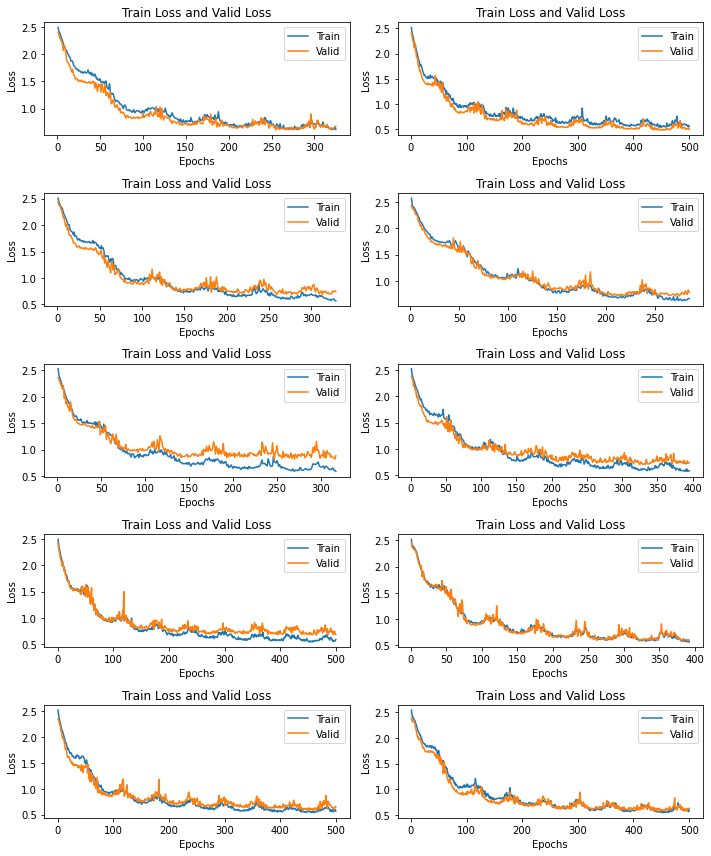

In [41]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(5, 2, figsize=(10, 12))
for i, ax in enumerate(axs.flatten()):
    show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 11개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [42]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값 

In [56]:
seed_everything(SEED)
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=get_transform(train_mode=False))  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
net = CNN().to(device)

In [58]:
pred = predict(net, test_dataloader, SAVE_PATH)

In [59]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [60]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8


In [49]:
submission.to_csv('./Data/submission3.csv', index=False)

### TTA 기법

In [43]:
def TTA_predict(model: nn.Module, dataloader, weight_save_path, n_tta: int = 5) -> np.array:
    """
    test_time_augmentation(test에도 transform을 적용, 일반화 능력 향상)를 사용하여 dataloader의 데이터를 예측
    dataloader에는 transform이 적용된 dataset을 가지고 있어야 함
    n_tta 횟수만큼 predict를 반복한다
    이 과정에서 여러번(n_tta) 무작위로 transform이 적용된 images의 각 label별 확률값들의 평균을 계산 후 최대값을 가지는 label을 반환한다
    """
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수
    for i in tqdm(range(n_tta)):
        test_probs += (predict(net, test_dataloader, SAVE_PATH, is_prob=True) / n_tta)

    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스
    return test_preds ## 라벨값

In [61]:
seed_everything(SEED)
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=get_transform(train_mode=True))  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [62]:
net = CNN().to(device)

In [63]:
pred = TTA_predict(net, test_dataloader, SAVE_PATH, n_tta=3)

100%|██████████| 3/3 [00:24<00:00,  8.33s/it]


In [64]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [66]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8


In [67]:
submission.to_csv('./Data/submission_TTA2.csv', index=False)

`-` TTA 기법을 적용한 예측과 적용하지 않은 예측은 동일한 결과였다

`-` 점수는 $0.953271028$